Drugie podejście do modelu

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os.path import join as JoinPath
from cmdstanpy import CmdStanModel

In [2]:
# Pozyskiwanie zależności
eh = pd.read_csv('electricity_household' + '.tsv', sep='\t',header=0, index_col='country')
eh_mean_list = list(eh.mean())

ei = pd.read_csv('electricity_industry' + '.tsv', sep='\t',header=0, index_col='country')
ei_mean_list = list(ei.mean())

gh = pd.read_csv('gas_household' + '.tsv', sep='\t',header=0, index_col='country')
gh = gh.drop(['1990-S2 '], axis=1) # Usunięcie wymagane poniewać eurostat wykonał tutaj jeden dodatkowy punkt pomiarowy
gh_mean_list = list(gh.mean())

gi = pd.read_csv('gas_industry' + '.tsv', sep='\t',header=0, index_col='country')
gi_mean_list = list(gi.mean())

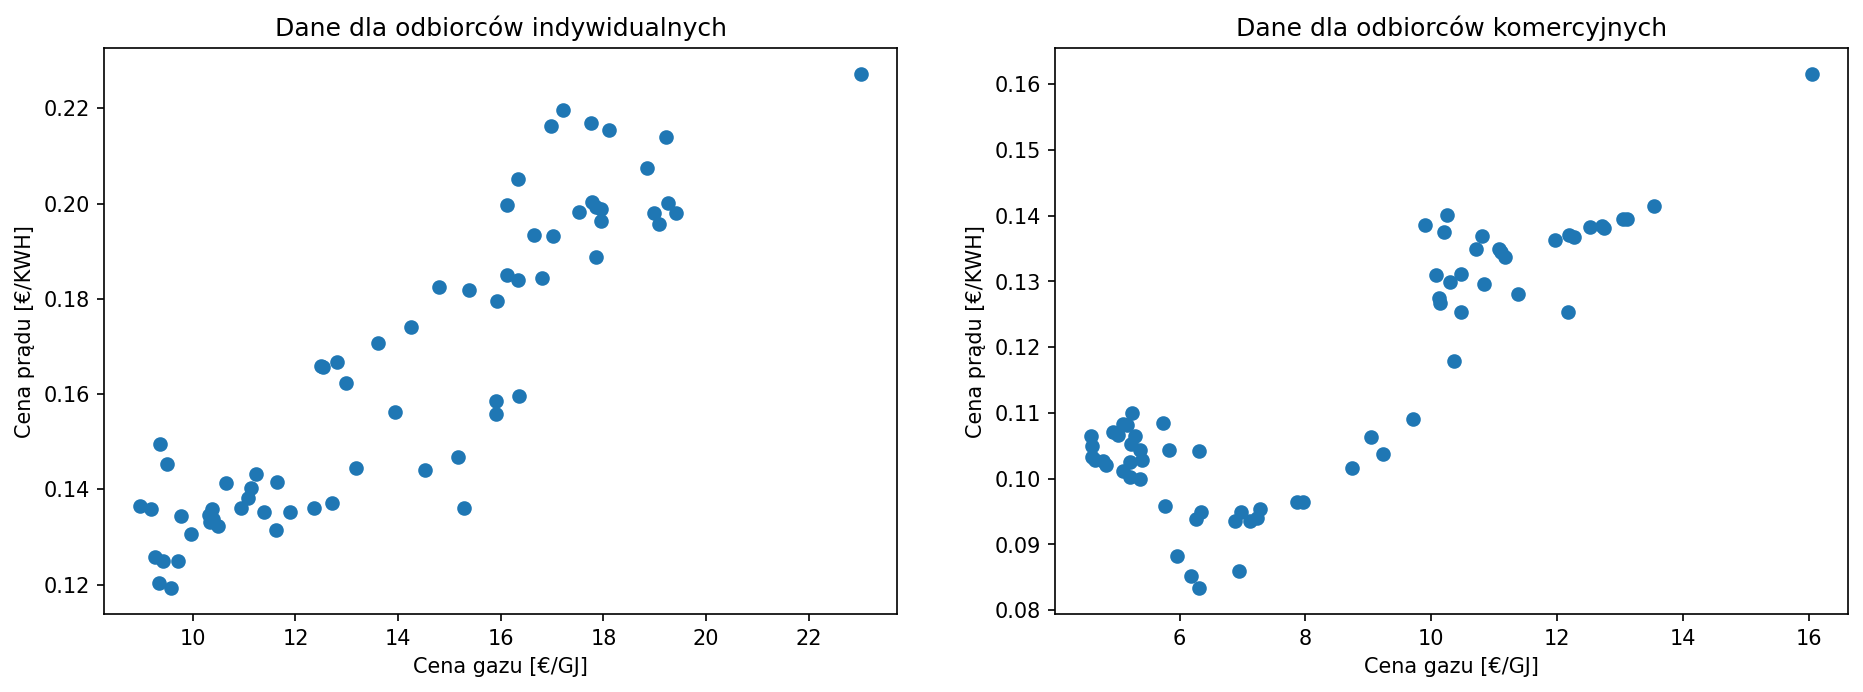

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), dpi=150)
plt.rcParams['axes.grid'] = True

ax1.plot(gh_mean_list, eh_mean_list, 'o')
ax1.set_title("Dane dla odbiorców indywidualnych")
ax1.set_xlabel("Cena gazu [€/GJ]")
ax1.set_ylabel("Cena prądu [€/KWH]")

ax2.plot(gi_mean_list, ei_mean_list, 'o')
ax2.set_title("Dane dla odbiorców komercyjnych")
ax2.set_xlabel("Cena gazu [€/GJ]")
ax2.set_ylabel("Cena prądu [€/KWH]")

plt.show()

# Obliczenia przy użyciu STAN

In [4]:
# Numer modelu oznacza stopień wielomianu dopasowania
model_1_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_1.stan'))
model_2_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_2.stan'))
model_3_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_3.stan'))
model_4_fit=CmdStanModel(stan_file=JoinPath('stan-files', 'model_4.stan'))

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiling stan file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_4.stan to exe file E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_4.exe
INFO:cmdstanpy:compiled model executable: E:\Obiekty 3D\GitHub\Projekt-DataAnalytics-2022\Source_Code\stan-files\model_4.exe


In [5]:
def fit(model, x, y):
    data = {}
    data['N'] = len(x)
    data['x'] = x
    data['y'] = y
    return model.sample(data=data, seed=2137)

In [6]:
h_fit_degree1 = fit(model_1_fit, gh_mean_list, eh_mean_list)
h_fit_degree2 = fit(model_2_fit, gh_mean_list, eh_mean_list)
h_fit_degree3 = fit(model_3_fit, gh_mean_list, eh_mean_list)
h_fit_degree4 = fit(model_4_fit, gh_mean_list, eh_mean_list)

i_fit_degree1 = fit(model_1_fit, gi_mean_list, ei_mean_list)
i_fit_degree2 = fit(model_2_fit, gi_mean_list, ei_mean_list)
i_fit_degree3 = fit(model_3_fit, gi_mean_list, ei_mean_list)
i_fit_degree4 = fit(model_4_fit, gi_mean_list, ei_mean_list)

INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:04 Iteration: 1300 / 2000 [ 65%]  (Sam


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:04 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:05 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:05 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:06 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:07 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:08 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:09 Iteration: 1300 / 2000 [ 65%]  (S


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start procesing
chain 1 |          | 00:00 Status



chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████▌     | 00:05 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:06 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:07 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:11 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:12 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status




chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)






chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:03 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:04 Iteration: 1400 / 2000 [ 7


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:03 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:04 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:05 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:07 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:07 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:08 Iteration: 1400 / 2000 [ 70%]


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██▋       | 00:03 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:04 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:05 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:06 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:07 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:08 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:09 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:10 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:11 Iteration: 1400 / 2000 [ 70%]  (Sam


INFO:cmdstanpy:CmdStan done processing.


# Wyświetlanie danych wynikowych dopasowania

In [33]:
def PlotFitedData(x, y, fit_data, fit_degree, ax):
    alpha = np.mean(fit_data.stan_variable("alpha"))
    beta = np.mean(fit_data.stan_variable("beta"))
    gamma = None
    if fit_degree > 1:
        gamma = np.mean(fit_data.stan_variable("gamma"))
    delta = None
    if fit_degree > 2:
        delta = np.mean(fit_data.stan_variable("delta"))
    epsilon = None
    if fit_degree > 3:
        epsilon = np.mean(fit_data.stan_variable("epsilon"))
    sigma = np.mean(fit_data.stan_variable("sigma"))
    y_sim_to_mean = fit_data.stan_variable("y_sim")

    y_sim = []
    for i in range(len(x)):
        y_sim.append(y_sim_to_mean[2,i])

    dev = []
    if fit_degree == 1:
        dev = [alpha + beta*x_ for x_ in x]
    elif fit_degree == 2:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) for x_ in x]
    elif fit_degree == 3:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) + delta*pow(x_,3) for x_ in x]
    elif fit_degree == 4:
        dev = [alpha + beta*x_ + gamma*pow(x_,2) + delta*pow(x_,3) + epsilon*pow(x_,4) for x_ in x]
    else:
        print('Brak implementacji plotowania rzędu dopasowania')
        return None
    
    print(f'Dopasowanie wielomianem rzędu = {fit_degree}, alpha = {alpha}, beta = {beta}, gamma = {gamma}, delta = {delta}, epsilon = {epsilon}')
    
    upper_dev = [dev_ + sigma for dev_ in dev]
    lower_dev = [dev_ - sigma for dev_ in dev]

    ax.plot(x, y, 'ro', label='Orginalne dane')
    ax.plot(x, y_sim, 'bo', label='Wygenerowane dane')
    ax.plot(sorted(x), sorted(dev), 'tab:purple', label='Maksimum rozkładu normalnego')
    ax.plot(sorted(x), sorted(upper_dev), 'tab:orange', label='Dolne odchylenie rozkładu normalnego')
    ax.plot(sorted(x), sorted(lower_dev), 'tab:green', label='Górne odchylenie rozkładu normalnego')
    ax.set_xlabel("Cena gazu [€/GJ]")
    ax.set_ylabel("Cena prądu [€/KWH]")

    if fit_degree == 1:
        ax.set_title('Model α + βx\nα={:.5f},β={:.5f}'.format(alpha, beta))
    elif fit_degree == 2:
        ax.set_title('Model α + βx + γx^2\nα={:.5f},β={:.5f},γ={:.5f}'.format(alpha, beta, gamma))
    elif fit_degree == 3:
        ax.set_title('Model α + βx + γx^2 + δx^3\nα={:.5f},β={:.5f},γ={:.5f},δ={:.5f}'.format(alpha, beta, gamma, delta))
    elif fit_degree == 4:
        ax.set_title('Model α + βx + γx^2 + δx^3 + εx^4\nα={:.5f},β={:.5f},γ={:.5f},δ={:.5f},ε={:.5f}'.format(alpha, beta, gamma, delta, epsilon))

Dopasowanie wielomianem rzędu = 1, alpha = 0.051762158375000006, beta = 0.0080375394925, gamma = None, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 2, alpha = 0.064405229185105, beta = 0.006159774796824999, gamma = 6.5534113559875e-05, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 3, alpha = -0.8339716649999999, beta = 0.19026694500000002, gamma = -0.011941817275000002, delta = 0.00025116759050000003, epsilon = None
Dopasowanie wielomianem rzędu = 4, alpha = -0.6235565715, beta = 0.2531775932500001, gamma = -0.029922741275000008, delta = 0.0014941717274999996, epsilon = -2.6206626174999997e-05


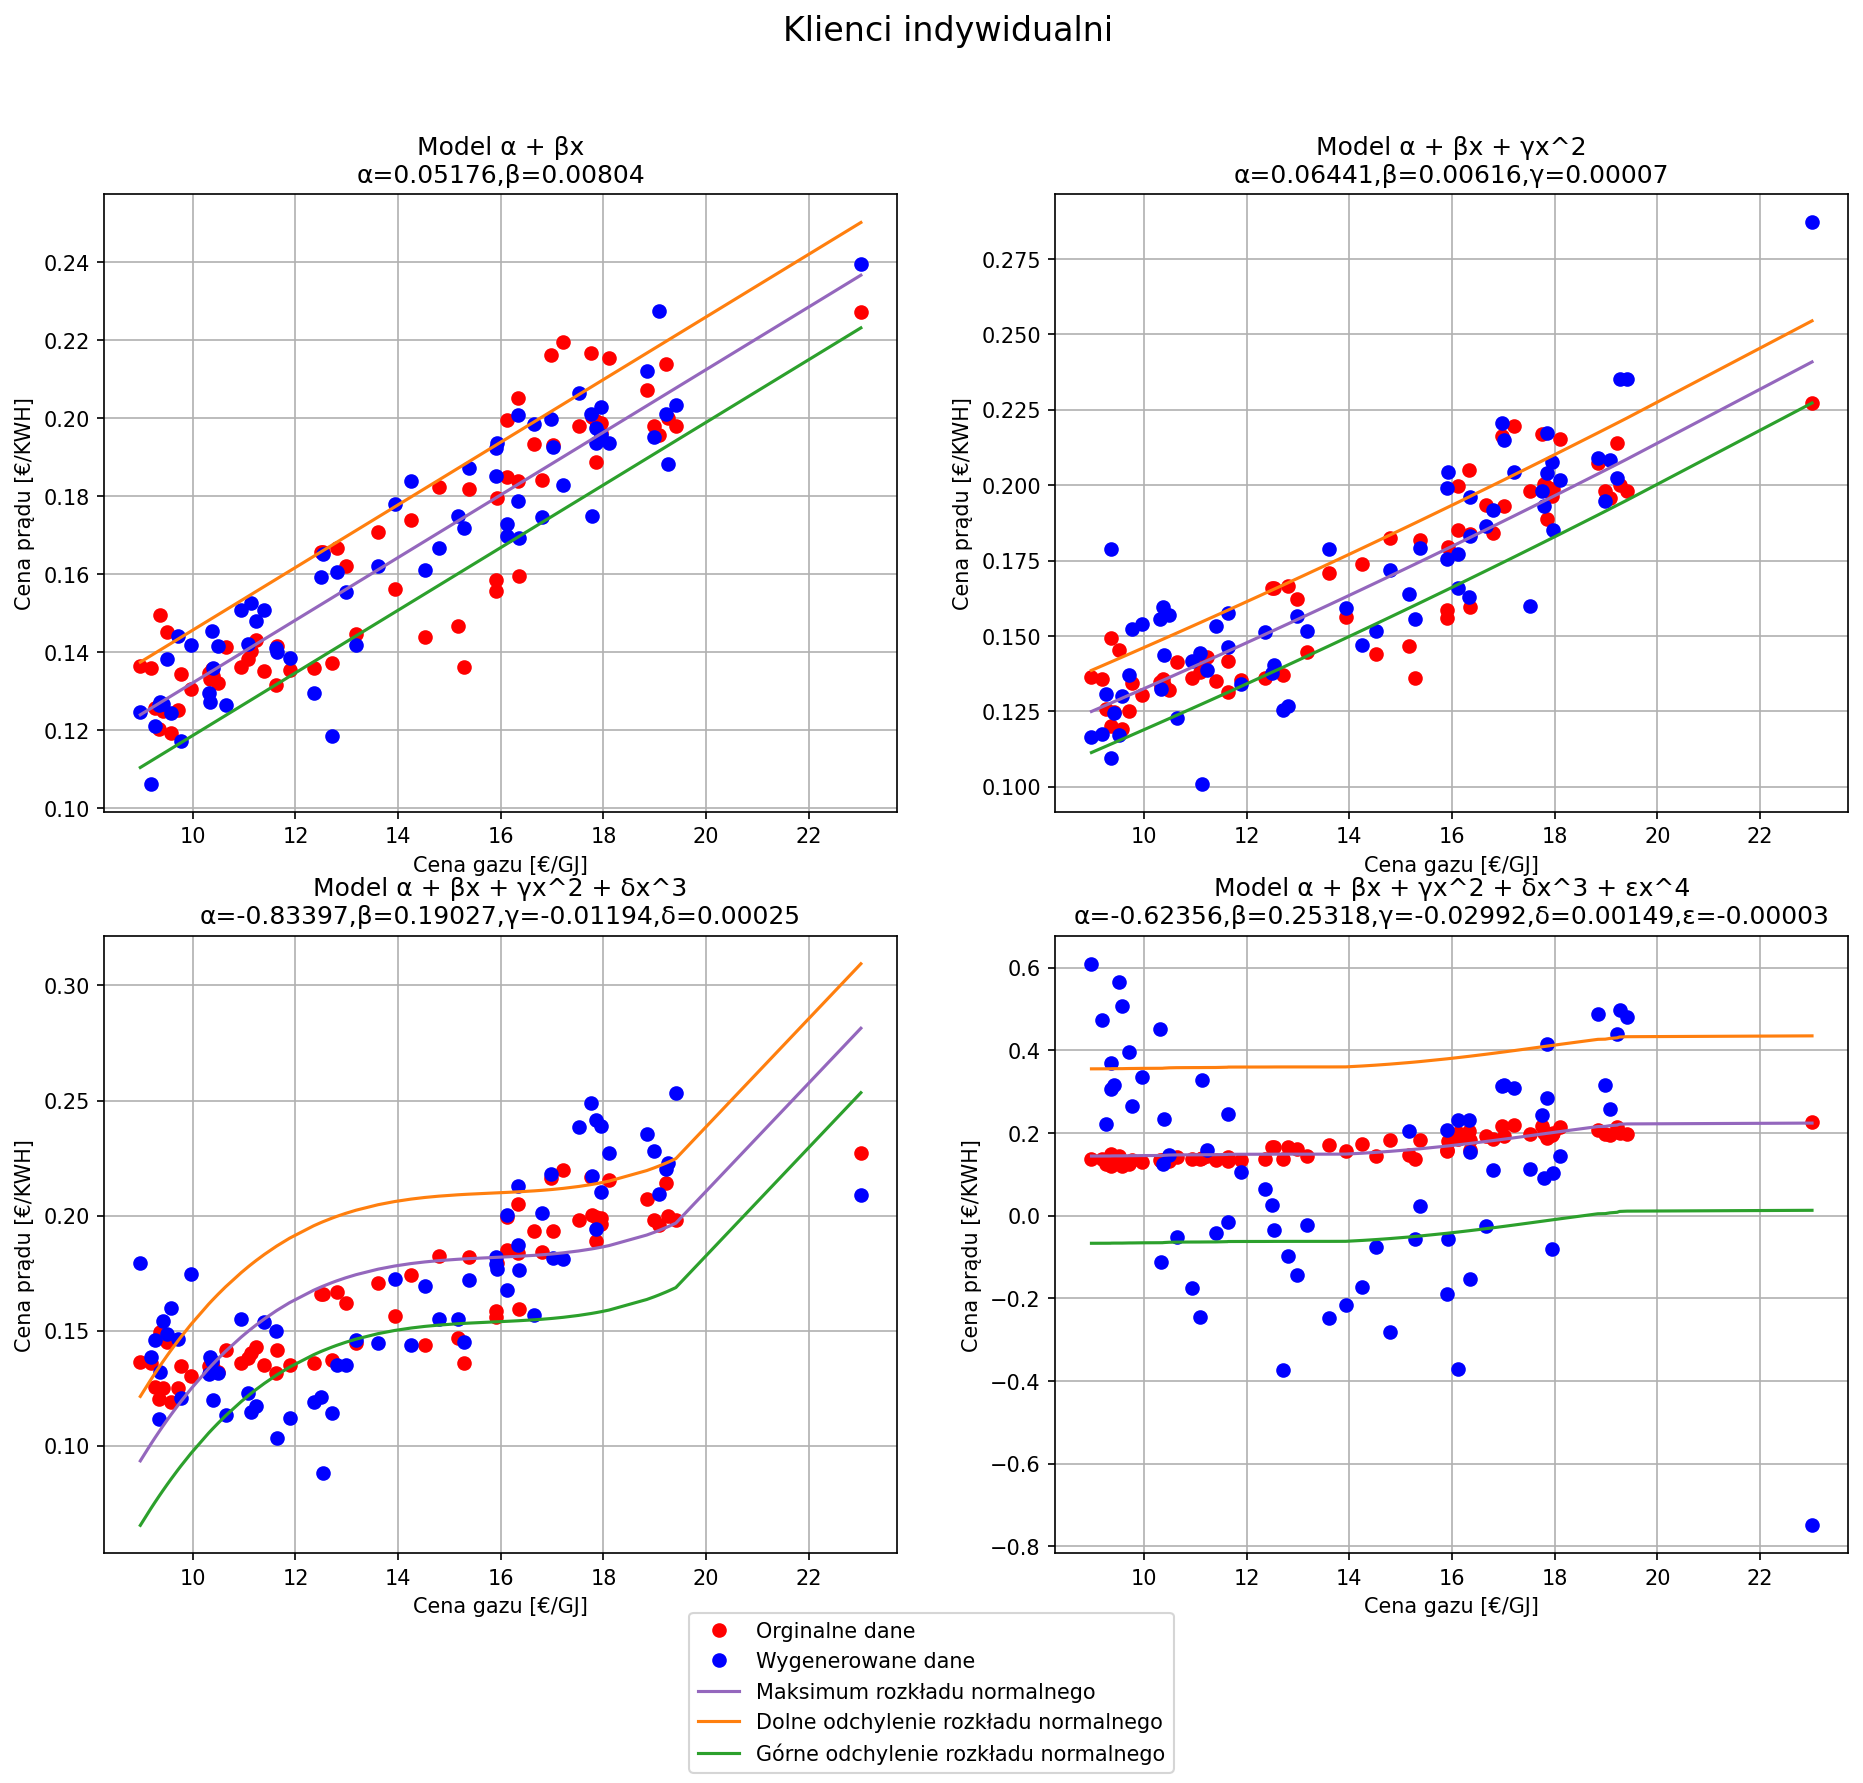

In [39]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree1, 1, axs[0, 0])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree2, 2, axs[0, 1])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree3, 3, axs[1, 0])
PlotFitedData(gh_mean_list, eh_mean_list, h_fit_degree4, 4, axs[1, 1])

f.suptitle('Klienci indywidualni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Dopasowanie klienci indywidualni.png', dpi=300)
plt.show()

Dopasowanie wielomianem rzędu = 1, alpha = 0.07074365265, beta = 0.0052427115324999995, gamma = None, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 2, alpha = 0.10255620955, beta = -0.00285755157398125, gamma = 0.00045571790562500003, delta = None, epsilon = None
Dopasowanie wielomianem rzędu = 3, alpha = 0.23694773350000004, beta = -0.05092484647500001, gamma = 0.0057005366375, delta = -0.00017836898349999998, epsilon = None
Dopasowanie wielomianem rzędu = 4, alpha = -0.864974489, beta = 0.43780547450000007, gamma = -0.070582702475, delta = 0.00484035963296375, epsilon = -0.0001182390593255


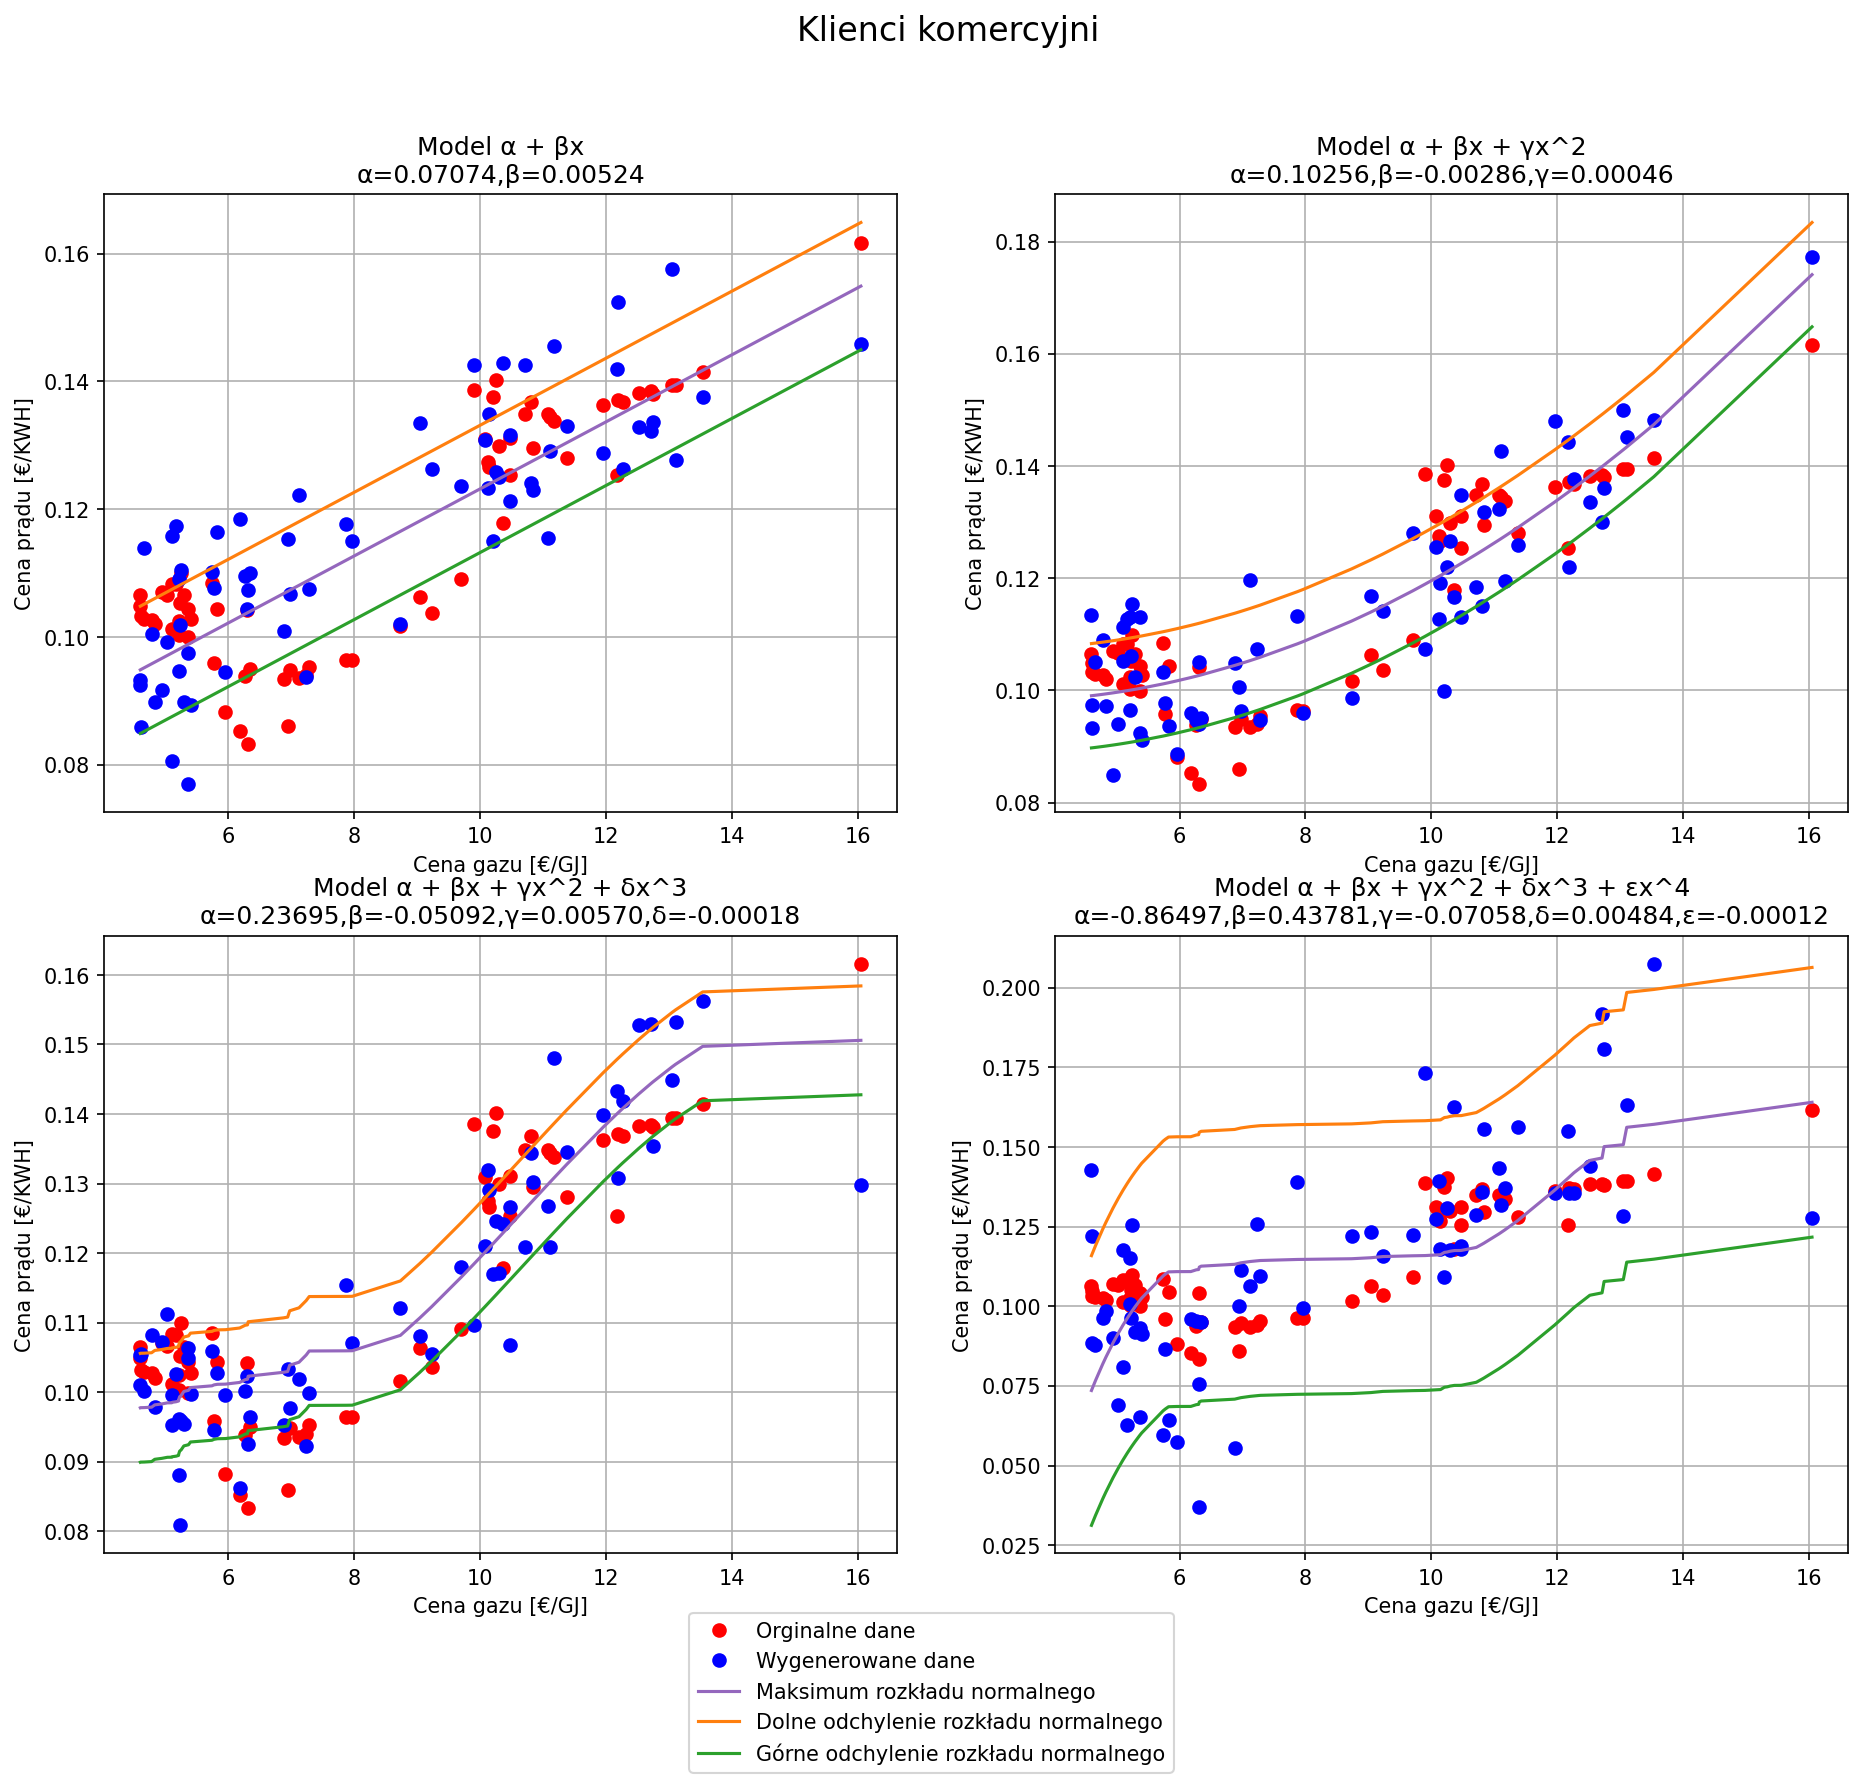

In [40]:
f, axs = plt.subplots(2, 2, figsize=(15,12), dpi=150)

PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree1, 1, axs[0, 0])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree2, 2, axs[0, 1])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree3, 3, axs[1, 0])
PlotFitedData(gi_mean_list, ei_mean_list, i_fit_degree4, 4, axs[1, 1])

f.suptitle('Klienci komercyjni', fontsize=16)
plt.rcParams['axes.grid'] = True
handles, labels = axs[0, 0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center')
plt.savefig('Dopasowanie klienci komercyjni.png', dpi=300)
plt.show()